In [1]:
from google.colab import drive
drive.mount('/content/drive')
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/content/drive/MyDrive/BTC.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test với tỉ kệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 13s 286ms/step - loss: 0.0309 - val_loss: 0.0027
Epoch 2/100
19/19 [==============================] - 4s 202ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 3/100
19/19 [==============================] - 5s 281ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 4/100
19/19 [==============================] - 4s 220ms/step - loss: 0.0023 - val_loss: 0.0054
Epoch 5/100
19/19 [==============================] - 4s 205ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/100
19/19 [==============================] - 4s 233ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 7/100
19/19 [==============================] - 5s 267ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 8/100
19/19 [==============================] - 4s 200ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 9/100
19/19 [==============================] - 4s 201ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 10/100
19/19 [==============================] - 6s 311ms/step - loss: 0.0017 - val_l

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 55ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=123
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.2792492  0.27851668 0.27126154 0.27764731 0.30246877 0.30400067
 0.30294467 0.30617488 0.30177358 0.30834598 0.30773789 0.30864925
 0.30792296 0.31920148 0.30487938 0.30943464 0.3187738  0.31413921
 0.3141952  0.31252488 0.3064937  0.30378449 0.31140356 0.3069385
 0.28870966 0.28626017 0.28975633 0.28862101 0.28840017 0.29502389
 0.32814094 0.31588107 0.33196058 0.33286106 0.32775213 0.33609749
 0.33005076 0.3259434  0.32205066 0.31046732 0.31007229 0.31617812
 0.31517344 0.30951863 0.31747673 0.31472709 0.29744849 0.29733496
 0.29859781 0.2983132  0.295013   0.28743904 0.26645899 0.26326922
 0.26810287 0.29185589 0.32482053 0.33392328 0.32743798 0.3386574
 0.37579161 0.3683685  0.38460821 0.38090365 0.38702348 0.37376826
 0.39008261 0.37688649 0.37709489 0.38483838 0.37171691 0.37377603
 0.39070004 0.38570931 0.39261764 0.39234392 0.38833454 0.38217272
 0.38780731 0.38794884 0.38582129 0.38385703 0.38433604 0.3903299
 0.41077183 0.41961486 0.41458836 0.42238006 0.423703

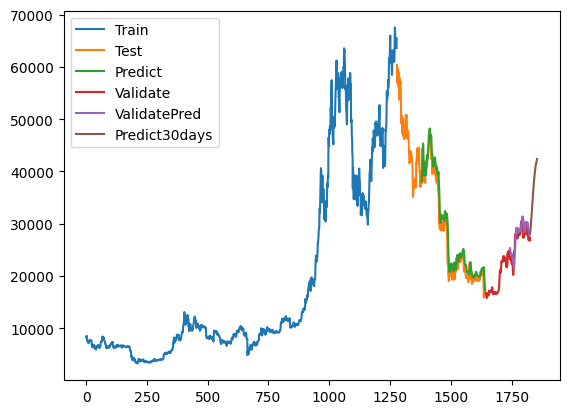

In [17]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [13]:
# Respliting train test
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]
# Repredictions on the testing set
x_test1 = np.array(test_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_test1 = np.array(test_data1['Price'])

# Repredictions on the validation set
x_val1 = np.array(val_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_val1 = np.array(val_data1['Price'])

In [14]:
# Calculate evalution
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 7332.600524335207
Testing RMSE: 15542.963646990336
Validation MAPE: 30.875789875839242
Testing MAPE: 38.14382123376176
Validation MAE: 5952.171050983827
Testing MAE: 12226.16410782969
